# 多变量股价预测-LSTM
训练集时间范围：2001-01-25到2021-09-29,预测目标列为Open

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import train_test_split

In [125]:
import tensorflow as tf

## 数据探索

In [2]:
df=pd.read_csv("train.csv",parse_dates=["Date"],index_col=[0])

In [4]:
# print(df.index.freq)
df.shape

(5203, 5)

In [5]:
df.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2001-01-25,356.730774,362.980774,352.403839,353.365387,197.122452
2001-01-26,357.211548,360.096161,342.788452,343.269226,191.490234
2001-01-29,345.153839,355.769226,338.461548,341.384613,190.439011
2001-01-30,344.307678,355.923065,341.692322,355.769226,198.463318
2001-01-31,359.615387,361.153839,350.461548,353.692322,197.304749


In [6]:
df.tail()

,Open,High,Low,Close,Adj Close
Date,,,,,
2021-09-23,99.529999,104.080002,99.519997,102.959999,102.789993
2021-09-24,102.660004,104.199997,102.599998,103.800003,103.709198
2021-09-27,104.550003,106.330002,104.389999,105.349998,105.257835
2021-09-28,105.290001,106.750000,104.730003,105.730003,105.637512
2021-09-29,106.000000,107.000000,105.309998,106.279999,106.187027


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5203 entries, 2001-01-25 to 2021-09-29
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5203 non-null   float64
 1   High       5203 non-null   float64
 2   Low        5203 non-null   float64
 3   Close      5203 non-null   float64
 4   Adj Close  5203 non-null   float64
dtypes: float64(5)
memory usage: 243.9 KB


## 划分数据集

In [16]:
df_for_training,df_for_testing = train_test_split(df,test_size=0.2,shuffle=False) # 时间序列划分时一定要设shuffle=False

In [17]:
print(df_for_training.shape)
print(df_for_testing.shape)

(4162, 5)
(1041, 5)


## 准备序列数据

- 数据归一

数据范围非常大，并且它们没有在相同的范围内缩放，因此为了避免预测错误，让我们先使用MinMaxScaler缩放数据。(也可以使用StandardScaler)

In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)

In [22]:
df_for_training_scaled

array([[0.85398707, 0.86281807, 0.85292546, 0.8403402 , 0.82180889],
       [0.85533406, 0.85473269, 0.82623316, 0.8122593 , 0.79289309],
       [0.82155169, 0.84260459, 0.81422168, 0.80701755, 0.78749611],
       ...,
       [0.40689652, 0.40362224, 0.41960282, 0.40436458, 0.7632948 ],
       [0.40517242, 0.39995691, 0.41832161, 0.4075738 , 0.76889077],
       [0.40862067, 0.39974127, 0.41426436, 0.39880189, 0.75359571]])

In [23]:
print(df_for_training_scaled.shape,df_for_testing_scaled.shape)

(4162, 5) (1041, 5)


In [ ]:
# # 3 构造批数据

# def create_batch_dataset(X, y, train=True, buffer_size=1000, batch_size=128):
#     batch_data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # 数据封装，tensor类型
#     if train: # 训练集
#         return batch_data.cache().shuffle(buffer_size).batch(batch_size)
#     else: # 测试集
#         return batch_data.batch(batch_size)
    
# # 训练批数据
# train_batch_dataset = create_batch_dataset(train_dataset, train_labels)

# # 测试批数据
# test_batch_dataset = create_batch_dataset(test_dataset, test_labels, train=False)

- 准备数据

这里用过去n_past个样本来预测当前

In [24]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]]) # X：过去n_past行，除Open之外的列
            dataY.append(dataset[i,0]) # Y：i行，Open列
    return np.array(dataX),np.array(dataY)        

In [28]:
trainX,trainY=createXY(df_for_training_scaled,30)
testX,testY=createXY(df_for_testing_scaled,30)

In [27]:
trainX[0]

array([[0.85398707, 0.86281807, 0.85292546, 0.8403402 , 0.82180889],
       [0.85533406, 0.85473269, 0.82623316, 0.8122593 , 0.79289309],
       [0.82155169, 0.84260459, 0.81422168, 0.80701755, 0.78749611],
       [0.81918098, 0.84303579, 0.82319031, 0.8470261 , 0.8286929 ],
       [0.86206895, 0.85769729, 0.84753366, 0.84124952, 0.8227448 ],
       [0.85668106, 0.85295391, 0.85479397, 0.84659822, 0.82825271],
       [0.85129307, 0.85661925, 0.85372629, 0.84766796, 0.82935384],
       [0.8540948 , 0.88249248, 0.85799703, 0.88125807, 0.86394198],
       [0.88577588, 0.88227684, 0.88255396, 0.87590928, 0.85843431],
       [0.88189657, 0.87602422, 0.87016871, 0.86200256, 0.84411479],
       [0.88362063, 0.88357053, 0.87892376, 0.86606763, 0.84829995],
       [0.87047413, 0.86200956, 0.84390347, 0.8344031 , 0.81569511],
       [0.83857758, 0.87645542, 0.84966903, 0.87398378, 0.85645156],
       [0.88168102, 0.88012075, 0.88105913, 0.86649551, 0.84874037],
       [0.87090514, 0.86287196, 0.

In [30]:
trainY[0]

0.8297413960482309

In [29]:
# 生成4132个序列，每个序列有30个时间步，5个特征
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

trainX Shape--  (4132, 30, 5)
trainY Shape--  (4132,)
testX Shape--  (1011, 30, 5)
testY Shape--  (1011,)


## 建模

In [54]:
# import keras_tuner
# from keras_tuner.tuners import Hyperband
# from keras_tuner.engine.hyperparameters import HyperParameters

In [86]:
def build_model(optimizer='adam'):
    model = Sequential([
        LSTM(50,return_sequences=True,input_shape=(30,5)),
        LSTM(50),
        Dropout(0.2),
        Dense(1)  
    ])
    model.compile(loss = 'mse',optimizer = optimizer)
    return model

In [87]:
# 用网格搜索，用KerasClassifier或KerasRegressor类包装Keras模型，可将其用于scikit-learn。
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [88]:
# grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
grid_model = KerasRegressor(build_model,verbose=1,optimizer='adam')

In [89]:
parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }
grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

In [92]:
grid_search.fit(trainX,trainY,validation_data=(testX,testY))

Epoch 1/8
130/130 [==============================] - 10s 46ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 2/8
130/130 [==============================] - 5s 41ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 3/8
130/130 [==============================] - 6s 42ms/step - loss: 9.4518e-04 - val_loss: 0.0017
Epoch 4/8
130/130 [==============================] - 6s 45ms/step - loss: 8.7630e-04 - val_loss: 0.0015
Epoch 5/8
130/130 [==============================] - 7s 56ms/step - loss: 8.8658e-04 - val_loss: 0.0019
Epoch 6/8
130/130 [==============================] - 8s 61ms/step - loss: 7.9020e-04 - val_loss: 0.0014
Epoch 7/8
130/130 [==============================] - 8s 61ms/step - loss: 7.2217e-04 - val_loss: 0.0014
Epoch 8/8
130/130 [==============================] - 3s 11ms/step
Epoch 1/8
130/130 [==============================] - 12s 52ms/step - loss: 0.0091 - val_loss: 0.0020
Epoch 2/8
130/130 [==============================] - 11s 83ms/step - loss: 0.0030 - val_loss: 3.2023e-04
Epoch 3

GridSearchCV(cv=2,
             estimator=KerasRegressor(model=<function build_model at 0x000001D009814B80>, optimizer='adam'),
             param_grid={'batch_size': [16, 20], 'epochs': [8, 10],
                         'optimizer': ['adam', 'Adadelta']})

In [98]:
my_model=grid_search.best_estimator_
print(f"最佳参数：{grid_search.best_params_}")

最佳参数：{'batch_size': 16, 'epochs': 10, 'optimizer': 'Adadelta'}


In [99]:
# 这里的模型其实已经和sklearn中的模型一样了，所有直接将testX扔进去是可以的
prediction=my_model.predict(testX)

64/64 [==============================] - 0s 6ms/step


In [100]:
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [0.37862605 0.38234293 0.38587564 ... 0.13034046 0.1329429  0.13605207]

Prediction Shape- (1011,)


- 将预测结果再缩放回去

In [35]:
scaler.inverse_transform(prediction)

ValueError: non-broadcastable output operand with shape (1011,1) doesn't match the broadcast shape (1011,5)

In [105]:
# 将预测结果转回缩放之前（缩放之前是1011*5,但prediction是1011*1，所以要复制5列出来）
prediction_copies_array = np.repeat(prediction.reshape((-1,1)),5, axis=-1)

In [106]:
prediction_copies_array

array([[0.37862605, 0.37862605, 0.37862605, 0.37862605, 0.37862605],
       [0.38234293, 0.38234293, 0.38234293, 0.38234293, 0.38234293],
       [0.38587564, 0.38587564, 0.38587564, 0.38587564, 0.38587564],
       ...,
       [0.13034046, 0.13034046, 0.13034046, 0.13034046, 0.13034046],
       [0.1329429 , 0.1329429 , 0.1329429 , 0.1329429 , 0.1329429 ],
       [0.13605207, 0.13605207, 0.13605207, 0.13605207, 0.13605207]],
      dtype=float32)

In [113]:
# 将预测值转回缩放前
# pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,0]
pred = scaler.inverse_transform(prediction_copies_array)[:,0]

In [117]:
# 将验证集的y也转回缩放前
original_copies_array = np.repeat(testY.reshape(-1,1),5, axis=-1)
original=scaler.inverse_transform(original_copies_array)[:,0]

In [119]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- ",original)

Pred Values--  [187.06346  188.39009  189.651    ...  98.444595  99.37346  100.4832  ]

Original Values--  [191.692307 193.461533 192.307693 ... 104.550003 105.290001 106.      ]


In [126]:
from sklearn.metrics import r2_score,mean_squared_error

In [127]:
# 计算r2值

score_r2 = r2_score(original, pred)
score_mse = mean_squared_error(original, pred)
print("r^2 值为： ", score_r2)
print("mse 值为： ", score_mse)

r^2 值为：  0.9794149303255905
mse 值为：  15.650433979692608


In [120]:
import matplotlib.pyplot as plt

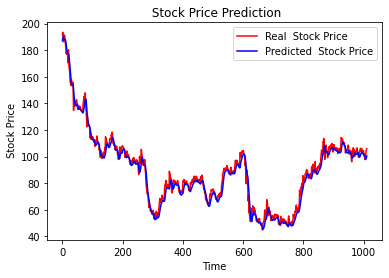

In [121]:
plt.plot(original, color = 'red', label = 'Real  Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

# 预测未来30天的股价

In [138]:
# 在训练数据中获取最后30天数据
df_30_days_past=df.iloc[-30:,:]

# 对要预测的数据添加一列Open，值初始化为0
df_30_days_future=pd.read_csv("test.csv",parse_dates=["Date"],index_col=[0])
df_30_days_future.insert(0,"Open",0)

In [139]:
display(df_30_days_past)
display(df_30_days_future)

,Open,High,Low,Close,Adj Close
Date,,,,,
2021-08-18,101.080002,103.470001,100.760002,101.410004,101.242561
2021-08-19,100.000000,100.820000,98.599998,99.419998,99.255844
2021-08-20,99.589996,100.669998,99.099998,100.050003,99.884804
2021-08-23,100.599998,101.480003,100.269997,100.970001,100.803284
2021-08-24,101.290001,103.510002,101.059998,103.269997,103.099487
2021-08-25,103.360001,105.129997,102.550003,104.699997,104.527122
2021-08-26,104.459999,104.620003,102.839996,103.379997,103.209305
2021-08-27,103.900002,106.150002,103.900002,106.089996,105.914825
2021-08-30,106.330002,106.459999,104.800003,105.190002,105.016312


,Open,High,Low,Close,Adj Close
Date,,,,,
2021-09-30,0,107.089996,102.949997,103.029999,102.939865
2021-10-01,0,106.389999,103.669998,105.820000,105.727425
2021-10-04,0,107.080002,104.599998,104.900002,104.808235
2021-10-05,0,106.000000,103.750000,104.900002,104.808235
2021-10-06,0,104.419998,102.059998,104.330002,104.238731
2021-10-07,0,106.529999,104.330002,105.510002,105.417702
2021-10-08,0,106.220001,104.660004,104.720001,104.628387
2021-10-11,0,105.760002,103.970001,104.080002,103.988953
2021-10-12,0,104.040001,101.559998,102.720001,102.630142


In [140]:
# 缩放
old_scaled_array=scaler.transform(df_30_days_past)
new_scaled_array=scaler.transform(df_30_days_future)

In [ ]:
new_scaled_array[]

In [149]:
pd.DataFrame(np.vstack((old_scaled_array,new_scaled_array)))

,0,1,2,3,4
0,0.137724,0.135427,0.154363,0.139566,0.329562
1,0.134698,0.127999,0.148366,0.134031,0.319362
2,0.133550,0.127579,0.149754,0.135783,0.322591
3,0.136379,0.129849,0.153002,0.138342,0.327306
4,0.138312,0.135539,0.155195,0.144739,0.339095
5,0.144112,0.140080,0.159332,0.148716,0.346425
6,0.147194,0.138650,0.160137,0.145045,0.339659
7,0.145625,0.142939,0.163079,0.152582,0.353549
8,0.152433,0.143808,0.165578,0.150079,0.348936
9,0.148539,0.143527,0.164634,0.150691,0.350064


In [144]:
np.concatenate(old_scaled_array,new_scaled_array)

TypeError: only integer scalar arrays can be converted to a scalar index

In [143]:



new_scaled_array

array([[-0.14547414,  0.14557351,  0.16044202,  0.14407146,  0.33827558],
       [-0.14547414,  0.14361147,  0.16244074,  0.15183141,  0.35258691],
       [-0.14547414,  0.1455455 ,  0.16502242,  0.14927258,  0.34786779],
       [-0.14547414,  0.14251833,  0.16266282,  0.14927258,  0.34786779],
       [-0.14547414,  0.13808969,  0.15797138,  0.14768721,  0.34494396],
       [-0.14547414,  0.14400388,  0.16427291,  0.1509692 ,  0.3509968 ],
       [-0.14547414,  0.14313498,  0.16518899,  0.14877193,  0.34694445],
       [-0.14547414,  0.14184563,  0.16327354,  0.14699188,  0.3436616 ],
       [-0.14547414,  0.13702458,  0.15658338,  0.14320925,  0.33668547],
       [-0.14547414,  0.13467011,  0.15552851,  0.14220796,  0.33483883],
       [-0.14547414,  0.13593144,  0.15883195,  0.14326486,  0.33678801],
       [-0.14547414,  0.14223804,  0.16110827,  0.14790972,  0.34535434],
       [-0.14547414,  0.13851014,  0.16069187,  0.14710313,  0.34386677],
       [-0.14547414,  0.13963131,  0.1

In [104]:
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

In [105]:
full_df.shape

(60, 5)

In [106]:
full_df.tail()

,0,1,2,3,4
55,NaN,0.143640,0.164162,0.150135,0.349458
56,NaN,0.152749,0.171268,0.159953,0.367565
57,NaN,0.154599,0.175349,0.159063,0.365924
58,NaN,0.171024,0.181345,0.167045,0.380645
59,NaN,0.161242,0.174766,0.160565,0.368694


In [107]:
full_df.shape

(60, 5)

In [114]:
full_df_scaled_array=full_df.values

In [115]:
full_df_scaled_array.shape

(60, 5)

In [116]:
all_data=[]
time_step=30
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(full_df_scaled_array[i-time_step:i,0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=my_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

In [117]:
all_data

[array([[0.1378213]], dtype=float32),
 array([[0.13945529]], dtype=float32),
 array([[0.14068112]], dtype=float32),
 array([[0.14162877]], dtype=float32),
 array([[0.14216018]], dtype=float32),
 array([[0.14206707]], dtype=float32),
 array([[0.1421535]], dtype=float32),
 array([[0.14225037]], dtype=float32),
 array([[0.14217126]], dtype=float32),
 array([[0.14150538]], dtype=float32),
 array([[0.14047278]], dtype=float32),
 array([[0.13954498]], dtype=float32),
 array([[0.13914707]], dtype=float32),
 array([[0.13891666]], dtype=float32),
 array([[0.13893819]], dtype=float32),
 array([[0.13930015]], dtype=float32),
 array([[0.13948296]], dtype=float32),
 array([[0.13946058]], dtype=float32),
 array([[0.13963053]], dtype=float32),
 array([[0.14062819]], dtype=float32),
 array([[0.14126904]], dtype=float32),
 array([[0.14153312]], dtype=float32),
 array([[0.1416432]], dtype=float32),
 array([[0.14201452]], dtype=float32),
 array([[0.14254372]], dtype=float32),
 array([[0.14292328]], dtype

In [118]:
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,5, axis=-1)
y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),5)))[:,0]

In [119]:
y_pred_future_30_days

array([101.11468 , 101.69789 , 102.135414, 102.473656, 102.66332 ,
       102.6301  , 102.66094 , 102.69551 , 102.66728 , 102.4296  ,
       102.06105 , 101.7299  , 101.58788 , 101.50563 , 101.51332 ,
       101.64251 , 101.70776 , 101.69977 , 101.76044 , 102.11652 ,
       102.34525 , 102.43951 , 102.478806, 102.61133 , 102.80022 ,
       102.93569 , 102.98711 , 103.2831  , 103.732796, 104.54266 ],
      dtype=float32)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [ ]:
mymodel.save('Model_future_value.h5')
print('Model Saved!')

In [ ]:
scaler

In [ ]:
import pickle
scalerfile = 'scaler_model_future_value.pkl'
pickle.dump(scaler, open(scalerfile, 'wb'))

# END!!!!